# 1 - Learning for Pricing

Consider the case in which all the users belong to class C1. Assume that the curves related to the advertising part of the problem are known, while the curve related to the pricing problem is not. Apply the UCB1 and TS algorithms, reporting the plots of the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from utils.clairvoyant_tools import get_optimal_parameters
from utils.User_Classes import UserClass
from utils.UCB import *
from utils.learners.Learner import *
import numpy as np
import matplotlib.pyplot as plt
from p1.pricing_environment import *
from p1.TS_learner import TS_Learner
from tqdm import tqdm
from utils.parameters import *

## Working in the enviroment

In [75]:
optimum_price, optimum_bid, opt = get_optimal_parameters(uc1.user_index)
optimum_price

150

In [62]:
n_arms = 5

uc1 = UserClass(name = "C1")
costs = [price * 0.3 for price in prices]
p = uc1.get_conversion_probabilities()
opt = p[3] #optimal arm is the one with the highest probability of success
env = Environment_Pricing(n_arms=n_arms, p = p)
prices = env.prices
margins = [price * 0.7 for price in prices]

T = 365 #time steps for each experiment

optimum_price, optimum_bid, opt = get_optimal_parameters(uc1.user_index)
n_experiments = 1000

ts_chose_3 = []
ucb_chose_2 = []

ts_rewards_per_experiment = [] #list to store the collected rewards for TS_Learner over each experiment
ucb_reward_per_experiment = [] #list to store the collected rewards for Greedy_Learner over each experiment
pulled_arm_number_TS = np.array([0 for i in range(0,5)])
pulled_arm_number_UCB = np.array([0 for i in range(0,5)])
# Loop over the experiments
for e in tqdm(range(0, n_experiments)):
    
    ts_chose_3 = []
    ucb_chose_2 = []
    env_pr = Environment_Pricing(n_arms=n_arms, p = p)
    ts_learner = TS_Learner(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    for t in range(0,T):
        #Thompson sampling
        pulled_arm = ts_learner.pull_arm()
        reward = env_pr.round(class_index=0, price_index=pulled_arm, bid = optimum_bid)
        #print(reward)
        ts_learner.update(pulled_arm, reward/34627)
        ts_learner.update_observations(pulled_arm, reward)
        pulled_arm_number_TS[pulled_arm] += 1
        if pulled_arm == 2:
            ts_chose_3.append(True)
        else:
            ts_chose_3.append(False)
        
        # Greedy
        pulled_arm = ucb_learner.pull_arm()
        reward = env_pr.round(class_index=0, price_index = pulled_arm, bid = optimum_bid)
        ucb_learner.update(pulled_arm, reward)
        pulled_arm_number_UCB[pulled_arm] += 1
        if pulled_arm == 1:
            ucb_chose_2.append(True)
        else:
            ucb_chose_2.append(False)
        


    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_reward_per_experiment.append(ucb_learner.collected_rewards)


# Compute the mean and standard deviation of the cumulative reward at each round
mean_cum_reward_ts = np.mean(ts_rewards_per_experiment, axis=0)
mean_cum_reward_ucb = np.mean(ucb_reward_per_experiment, axis=0)

std_cum_reward_ts = np.std(ts_rewards_per_experiment, axis=0)
std_cum_reward_ucb = np.std(ucb_reward_per_experiment, axis=0)

reward_ts = mean_cum_reward_ts
reward_ucb = mean_cum_reward_ucb


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:40<00:00, 24.54it/s]


### Istantaneous reward

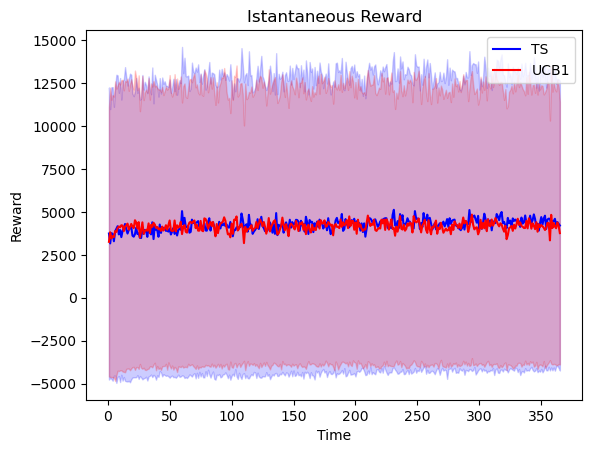

In [63]:
# Plot the results
plt.plot(range(1, T+1), reward_ts, 'b', label='TS')
plt.plot(range(1, T+1), reward_ucb, 'r', label='UCB1')

# Plot the standard deviation as a shaded region
plt.fill_between(range(1, T+1), reward_ts - std_cum_reward_ts, reward_ts + std_cum_reward_ts, alpha=0.2, color='b')
plt.fill_between(range(1, T+1), reward_ucb - std_cum_reward_ucb, reward_ucb + std_cum_reward_ucb, alpha=0.2, color='r')

plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Istantaneous Reward')
plt.legend()
plt.show()

### Cumulative reward

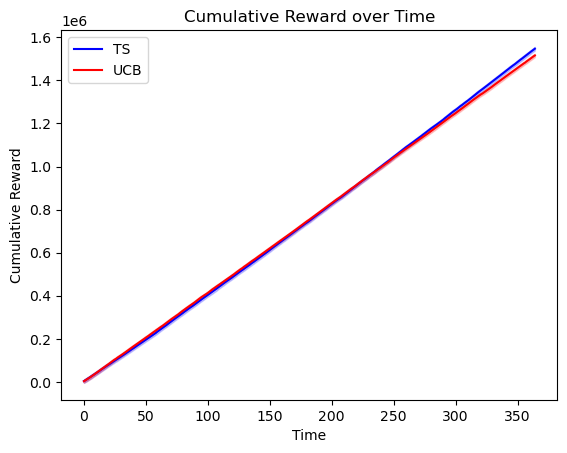

In [64]:
reward_ts_cum = np.cumsum(mean_cum_reward_ts)
reward_ucb_cum = np.cumsum(mean_cum_reward_ucb)

# Plot the mean cumulative rewards
plt.plot(reward_ts_cum, 'b', label='TS')
plt.plot(reward_ucb_cum, 'r', label='UCB')

# Plot the standard deviation as a shaded region
plt.fill_between(range(len(reward_ts_cum)), reward_ts_cum - std_cum_reward_ts, reward_ts_cum + std_cum_reward_ts, alpha=0.2, color='b')
plt.fill_between(range(len(reward_ucb_cum)), reward_ucb_cum - std_cum_reward_ucb, reward_ucb_cum + std_cum_reward_ucb, alpha=0.2, color='r')

plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()
plt.show()

### Cumulative regret

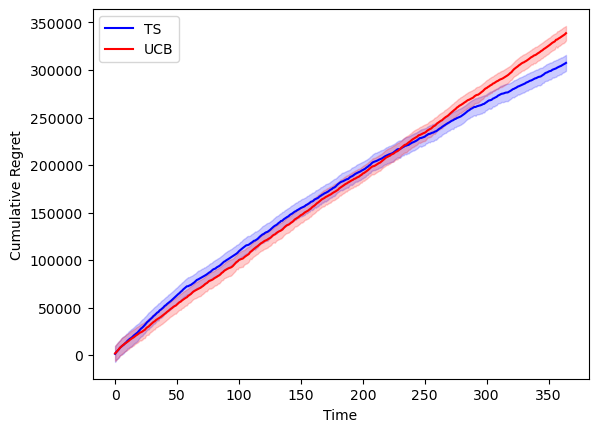

In [65]:
mean_cum_regret_ts = np.mean(opt - np.array(ts_rewards_per_experiment), axis=0)
std_cum_regret_ts = np.std(opt - np.array(ts_rewards_per_experiment), axis=0)

mean_cum_regret_ucb = np.mean(opt - np.array(ucb_reward_per_experiment), axis=0)
std_cum_regret_ucb = np.std(opt - np.array(ucb_reward_per_experiment), axis=0)

# Plot mean and standard deviation
plt.plot(np.cumsum(mean_cum_regret_ts), 'b', label='TS')
plt.plot(np.cumsum(mean_cum_regret_ucb), 'r', label='UCB')

plt.fill_between(range(len(mean_cum_regret_ts)), np.cumsum(mean_cum_regret_ts) - std_cum_regret_ts, np.cumsum(mean_cum_regret_ts) + std_cum_regret_ts, alpha=0.2, color='b')
plt.fill_between(range(len(mean_cum_regret_ucb)), np.cumsum(mean_cum_regret_ucb) - std_cum_regret_ucb, np.cumsum(mean_cum_regret_ucb) + std_cum_regret_ucb, alpha=0.2, color='r')

plt.ylabel("Cumulative Regret")
plt.xlabel("Time")
#plt.plot(np.cumsum(opt - np.array(mean_cum_reward_ts), axis=0), 'r')
plt.legend(["TS","UCB"])
plt.show()

### Istantaneous regret

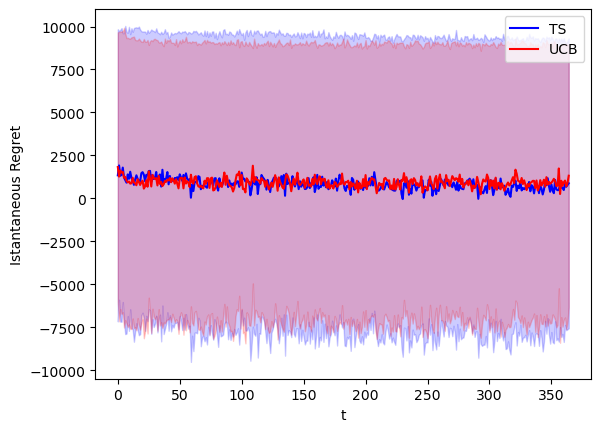

In [66]:
mean_inst_regret_ts = opt - np.mean(np.array(ts_rewards_per_experiment), axis=0)
std_inst_regret_ts = np.std(opt - np.array(ts_rewards_per_experiment), axis=0)

mean_inst_regret_ucb = opt - np.mean(np.array(ucb_reward_per_experiment), axis=0)
std_inst_regret_ucb = np.std(opt - np.array(ucb_reward_per_experiment), axis=0)

plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(mean_inst_regret_ts, 'b', label='TS')
plt.plot(mean_inst_regret_ucb, 'r', label='UCB')

plt.fill_between(range(len(mean_inst_regret_ts)), mean_inst_regret_ts - std_inst_regret_ts, mean_inst_regret_ts + std_inst_regret_ts, alpha=0.2, color='b')
plt.fill_between(range(len(mean_inst_regret_ucb)), mean_inst_regret_ucb - std_inst_regret_ucb, mean_inst_regret_ucb + std_inst_regret_ucb, alpha=0.2, color='r')

#plt.plot(np.mean(opt - np.array(ts_rewards_per_experiment), axis=0), 'r', label='TS')
plt.legend(["TS","UCB"])
plt.show()

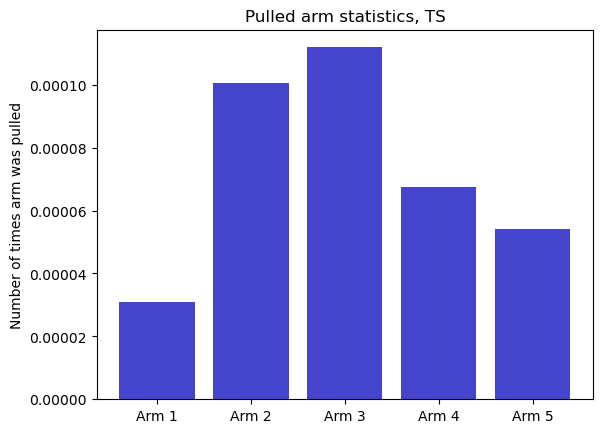

In [77]:
pulled_arm_number_TS = pulled_arm_number_TS.astype(np.float64) / 1000
pulled_arm_number_UCB = pulled_arm_number_UCB.astype(np.float64) / 1000

plt.bar(range(len(pulled_arm_number_TS)), pulled_arm_number_TS, color="#4444cc")
plt.xticks(range(len(pulled_arm_number_TS)), ['Arm 1', 'Arm 2', 'Arm 3', 'Arm 4', 'Arm 5'])
plt.ylabel('Number of times arm was pulled')
plt.title('Pulled arm statistics, TS')

plt.show()

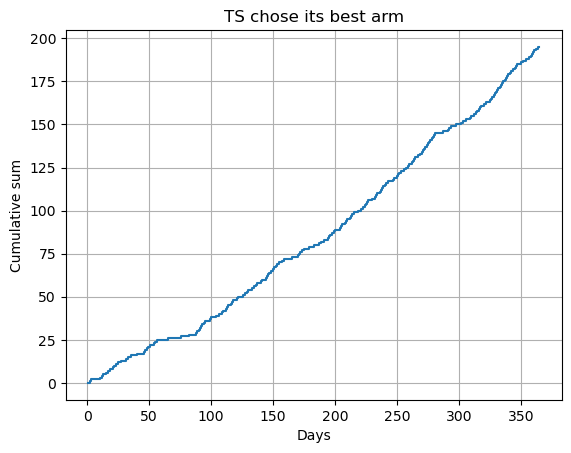

In [71]:
int_list = [int(b) for b in ts_chose_3]
cumulative_sum = np.cumsum(int_list)

# Plot cumulative sum as a step plot
plt.step(range(1, len(cumulative_sum) + 1), cumulative_sum)
plt.xlabel('Days')
plt.ylabel('Cumulative sum')
plt.title('TS chose its best arm')
plt.grid()
plt.show()

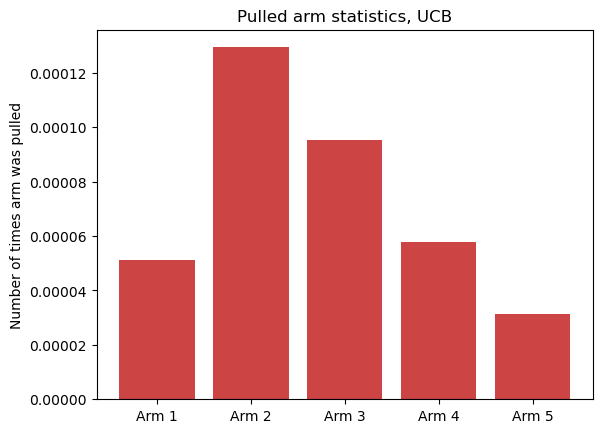

In [79]:
plt.bar(range(len(pulled_arm_number_UCB)), pulled_arm_number_UCB, color="#cc4444")
plt.xticks(range(len(pulled_arm_number_UCB)), ['Arm 1', 'Arm 2', 'Arm 3', 'Arm 4', 'Arm 5'])
plt.ylabel('Number of times arm was pulled')
plt.title('Pulled arm statistics, UCB')

plt.show()

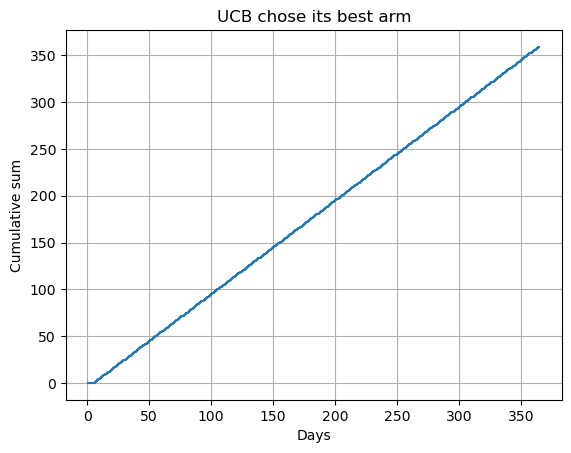

In [72]:
int_list = [int(b) for b in ucb_chose_2]
cumulative_sum = np.cumsum(int_list)

# Plot cumulative sum as a step plot
plt.step(range(1, len(cumulative_sum) + 1), cumulative_sum)
plt.xlabel('Days')
plt.ylabel('Cumulative sum')
plt.title('UCB chose its best arm')
plt.grid()
plt.show()